<a href="https://colab.research.google.com/github/rahul-t-p/wheatRust-Detection/blob/master/wheat_rust_model1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Description:
# Model -1
- efficientnet-b0
- Data Augmentation(224x224)
- Upsampling
- Stratified CV

# Kaggle initial setup

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
cd drive/My Drive/Colab Notebooks

/content/drive/My Drive/Colab Notebooks


In [0]:
#  from google.colab import files
#  files.upload()

In [0]:
 !pip install -q kaggle

In [0]:
 !mkdir -p ~/.kaggle
 !cp kaggle.json ~/.kaggle/

In [0]:
!chmod 600 ~/.kaggle/kaggle.json

In [7]:
cd /content/

/content


In [8]:
!kaggle datasets download -d hakymulla/cgiar-computer-vision-for-crop-disease

100% 2.99G/3.00G [00:54<00:00, 5.74MB/s]
100% 3.00G/3.00G [00:54<00:00, 58.8MB/s]


In [0]:
%%capture
!unzip cgiar-computer-vision-for-crop-disease.zip
!rm cgiar-computer-vision-for-crop-disease.zip

# Workspace setup

In [0]:
%%capture
!pip install -U catalyst
!pip install albumentations
!pip install -U efficientnet-pytorch

Restart runtime

In [0]:
# plotly configuration
import IPython

def configure_plotly_browser_state():
    display(IPython.core.display.HTML('''
        <script src="/static/components/requirejs/require.js"></script>
        <script>
          requirejs.config({
            paths: {
              base: '/static/base',
              plotly: 'https://cdn.plot.ly/plotly-latest.min.js?noext',
            },
          });
        </script>
        '''))


IPython.get_ipython().events.register('pre_run_cell', configure_plotly_browser_state)

In [4]:
%load_ext tensorboard

In [3]:
# a gif image is causing some problem while training so let's get rid of that
!rm ICLR/train/train/leaf_rust/*.gif

# Importing Packages

In [2]:
from typing import Callable, List, Tuple 

import os
import torch
import catalyst

from catalyst.dl import utils

print(f"torch: {torch.__version__}, catalyst: {catalyst.__version__}")

os.environ["CUDA_VISIBLE_DEVICES"] = "0"  # "" - CPU, "0" - 1 GPU, "0,1" - MultiGPU

SEED = 42
utils.set_global_seed(SEED)
utils.prepare_cudnn(deterministic=True)

alchemy not available, to install alchemy, run `pip install alchemy-catalyst`.


torch: 1.4.0, catalyst: 20.02.4


In [7]:
!nvidia-smi

Tue Feb 25 14:18:33 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.48.02    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P8     9W /  70W |     10MiB / 15079MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

# Dataset Preprocessing

In [8]:
from pathlib import Path

ROOT = "ICLR/"

In [9]:
from catalyst.utils import (
    create_dataset, create_dataframe, get_dataset_labeling, map_dataframe
)
dataset = create_dataset(dirs=f"{ROOT}train/train/*", extension="*")
df = create_dataframe(dataset, columns=["class", "filepath"])

tag_to_label = get_dataset_labeling(df, "class")
class_names = [
    name for name, id_ in sorted(tag_to_label.items(), key=lambda x: x[1])
]

df_with_labels = map_dataframe(
    df, 
    tag_column="class", 
    class_column="label", 
    tag2class=tag_to_label, 
    verbose=False
)
df_with_labels.head()

class                                    filepath  label
0  healthy_wheat  ICLR/train/train/healthy_wheat/03TD19.jfif      0
1  healthy_wheat   ICLR/train/train/healthy_wheat/0LBIWV.jpg      0
2  healthy_wheat  ICLR/train/train/healthy_wheat/0O5BON.jfif      0
3  healthy_wheat   ICLR/train/train/healthy_wheat/0PFX47.jpg      0
4  healthy_wheat  ICLR/train/train/healthy_wheat/1LNMUQ.jfif      0

Text(0.5, 1.0, 'Test Data')

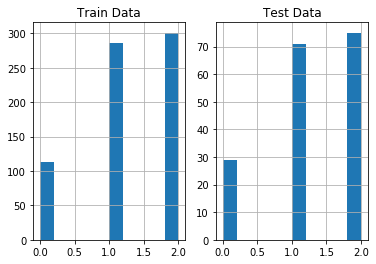

In [10]:
from catalyst.utils import split_dataframe_train_test
import matplotlib.pyplot as plt

train_data, valid_data = split_dataframe_train_test(
    df_with_labels, test_size=0.2, random_state=SEED, stratify=df_with_labels.label.to_numpy())

plt.subplot(1,2,1)
train_data.label.hist()
plt.title('Train Data')
plt.subplot(1,2,2)
valid_data.label.hist()
plt.title('Test Data')

Text(0.5, 1.0, 'Test Data')

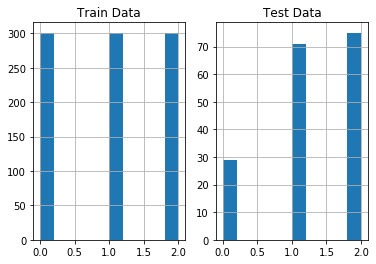

In [11]:
train_data = catalyst.utils.pandas.balance_classes(train_data, class_column='label',
                                                    random_state=SEED, how='upsampling')

plt.subplot(1,2,1)
train_data.label.hist()
plt.title('Train Data')
plt.subplot(1,2,2)
valid_data.label.hist()
plt.title('Test Data')

In [12]:
train_data, valid_data = (
    train_data.to_dict('records'), valid_data.to_dict('records')
)

In [13]:
from catalyst.dl import utils
from catalyst.data import ImageReader, ScalarReader, ReaderCompose
import numpy as np


num_classes = len(tag_to_label)

# ReaderCompose collects different Readers into one pipeline
open_fn = ReaderCompose([
    
    # Reads images from the `rootpath` folder 
    # using the key `input_key =" filepath "` (here should be the filename)
    # and writes it to the output dictionary by `output_key="features"` key
    ImageReader(
        input_key="filepath",
        output_key="features",
        rootpath=None
    ),
    
    # Reads a number from our dataframe 
    # by the key `input_key =" label "` to np.long
    # and writes it to the output dictionary by `output_key="targets"` key
    ScalarReader(
        input_key="label",
        output_key="targets",
        default_value=-1,
        dtype=np.int64
    ),
    
    # Same as above, but with one encoding
    ScalarReader(
        input_key="label",
        output_key="targets_one_hot",
        default_value=-1,
        dtype=np.int64, 
        one_hot_classes=num_classes
    )
])

# Augmentations

In [14]:
import albumentations as albu
from albumentations.pytorch import ToTensor

BORDER_CONSTANT = 0
BORDER_REFLECT = 2

def pre_transforms(image_size=224):
    # Convert the image to a square of size image_size x image_size
    # (keeping aspect ratio)
    result = [
        albu.LongestMaxSize(max_size=image_size),
        albu.PadIfNeeded(image_size, image_size, border_mode=BORDER_CONSTANT)
    ]
    
    return result

def hard_transforms():
    result = [
        # Random shifts, stretches and turns with a 50% probability
        albu.ShiftScaleRotate( 
            shift_limit=0.1,
            scale_limit=0.1,
            rotate_limit=15,
            border_mode=BORDER_REFLECT,
            p=0.5
        ),
        albu.VerticalFlip(),
        albu.IAAPerspective(scale=(0.02, 0.05), p=0.3),
        # Random brightness / contrast with a 30% probability
        albu.RandomBrightnessContrast(
            brightness_limit=0.2, contrast_limit=0.2, p=0.3
        ),
        # Random gamma changes with a 30% probability
        albu.RandomGamma(gamma_limit=(85, 115), p=0.3),
        # Randomly changes the hue, saturation, and color value of the input image
        albu.HueSaturationValue(p=0.3),
        albu.JpegCompression(quality_lower=80),
    ]
    
    return result

def post_transforms():
    # we use ImageNet image normalization
    # and convert it to torch.Tensor
    return [albu.Normalize(), ToTensor()]

def compose(transforms_to_compose):
    # combine all augmentations into one single pipeline
    result = albu.Compose([
      item for sublist in transforms_to_compose for item in sublist
    ])
    return result

In [15]:
from catalyst.data import Augmentor


train_transforms = compose([
    pre_transforms(), 
    hard_transforms(), 
    post_transforms()
])
valid_transforms = compose([pre_transforms(), post_transforms()])

show_transforms = compose([pre_transforms(), hard_transforms()])

# Takes an image from the input dictionary by the key `dict_key` 
# and performs `train_transforms` on it.
train_data_transforms = Augmentor(
    dict_key="features",
    augment_fn=lambda x: train_transforms(image=x)["image"]
)


# Similarly for the validation part of the dataset. 
# we only perform squaring, normalization and ToTensor
valid_data_transforms = Augmentor(
    dict_key="features",
    augment_fn=lambda x: valid_transforms(image=x)["image"]
)

In [16]:
from catalyst.utils import imread
import numpy as np

import matplotlib.pyplot as plt

def show_examples(images: List[Tuple[str, np.ndarray]]):
    _indexes = [(i, j) for i in range(2) for j in range(2)]
    
    f, ax = plt.subplots(2, 2, figsize=(9, 9))
    for (i, j), (title, img) in zip(_indexes, images):
        ax[i, j].imshow(img)
        ax[i, j].set_title(title)
    f.tight_layout()

def read_random_images(paths: List[Path]) -> List[Tuple[str, np.ndarray]]:
    data = np.random.choice(paths, size=4)
    result = []
    for d in data:
        title = f"{d.parent.name}: {d.name}"
        _image = imread(d)
        result.append((title, _image))
    
    return result

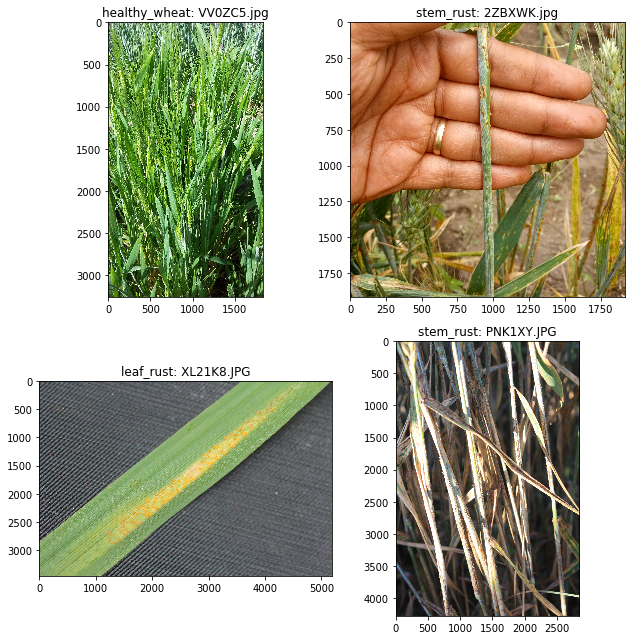

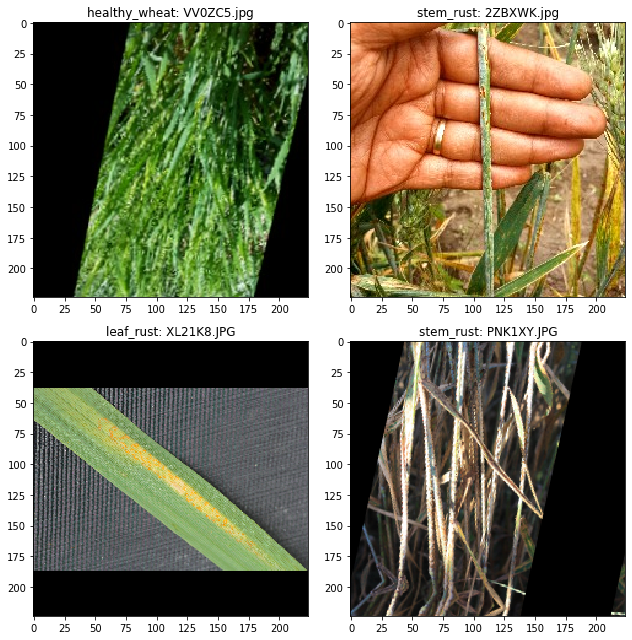

In [17]:
ALL_IMAGES = list(Path(ROOT).glob("train/train/*/*"))
ALL_IMAGES = list(filter(lambda x: not x.name.startswith("."), ALL_IMAGES))

images = read_random_images(ALL_IMAGES)
show_examples(images)
images = [
    (title, show_transforms(image=i)["image"])
    for (title, i) in images
]
show_examples(images)

# Data Loaders

In [18]:
import collections

is_fp16_used = False

def get_loaders(
    open_fn: Callable,
    train_transforms_fn,
    valid_transforms_fn,
    batch_size: int = 64, 
    num_workers: int = 4,
    sampler = None
) -> collections.OrderedDict:
    """
    Args:
        open_fn: Reader for reading data from a dataframe
        train_transforms_fn: Augmentor for train part
        valid_transforms_fn: Augmentor for valid part
        batch_size: batch size
        num_workers: How many subprocesses to use to load data,
        sampler: An object of the torch.utils.data.Sampler class 
            for the dataset data sampling strategy specification
    """
    train_loader = utils.get_loader(
        train_data,
        open_fn=open_fn,
        dict_transform=train_transforms_fn,
        batch_size=batch_size,
        num_workers=num_workers,
        shuffle=sampler is None, # shuffle data only if Sampler is not specified (PyTorch requirement)
        sampler=sampler,
        drop_last=True,
    )

    valid_loader = utils.get_loader(
        valid_data,
        open_fn=open_fn,
        dict_transform=valid_transforms_fn,
        batch_size=batch_size,
        num_workers=num_workers,
        shuffle=False, 
        sampler=None,
        drop_last=True,
    )

    # Catalyst expects an ordered dictionary with train/valid/infer loaders. 
    # The number of loaders can vary.
    # For example, it can easily handle even some complex logic like:
    # loaders["train_dataset1"] = train_loader_1
    # loaders["train_dataset2"] = train_loader_2
    # ....
    # loaders["valid_1"] = valid_loader_1
    # loaders["valid_2"] = valid_loader_2
    # ...
    # loaders["infer_1"] = infer_loader_1
    # loaders["infer_2"] = infer_loader_2
    # ...
    
    loaders = collections.OrderedDict()
    loaders["train"] = train_loader
    loaders["valid"] = valid_loader

    return loaders

if is_fp16_used:
    batch_size = 128
else:
    batch_size = 64

print(f"batch_size: {batch_size}")

loaders = get_loaders(
    open_fn=open_fn, 
    train_transforms_fn=train_data_transforms,
    valid_transforms_fn=valid_data_transforms,
    batch_size=batch_size,
)


batch_size: 64


# Model

In [19]:
from efficientnet_pytorch import EfficientNet

In [44]:
def get_model(n_classes):
    model = EfficientNet.from_pretrained('efficientnet-b0') 
    in_features = model._fc.in_features
    model._fc = torch.nn.Linear(in_features, n_classes)
    return model

model = get_model(3)

Loaded pretrained weights for efficientnet-b0


In [45]:
model

EfficientNet(
  (_conv_stem): Conv2dStaticSamePadding(
    3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False
    (static_padding): ZeroPad2d(padding=(0, 1, 0, 1), value=0.0)
  )
  (_bn0): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
  (_blocks): ModuleList(
    (0): MBConvBlock(
      (_depthwise_conv): Conv2dStaticSamePadding(
        32, 32, kernel_size=(3, 3), stride=[1, 1], groups=32, bias=False
        (static_padding): ZeroPad2d(padding=(1, 1, 1, 1), value=0.0)
      )
      (_bn1): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
      (_se_reduce): Conv2dStaticSamePadding(
        32, 8, kernel_size=(1, 1), stride=(1, 1)
        (static_padding): Identity()
      )
      (_se_expand): Conv2dStaticSamePadding(
        8, 32, kernel_size=(1, 1), stride=(1, 1)
        (static_padding): Identity()
      )
      (_project_conv): Conv2dStaticSamePadding(
        32, 16, kernel_size=

# Training

In [22]:
import torch
import torch.nn as nn

# as we are working on basic classification problem (no multi-class/multi-label)
# let's use standard CE loss
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)
scheduler = torch.optim.lr_scheduler.MultiStepLR(
    optimizer, milestones=[3], gamma=0.3
)

In [23]:
from catalyst.dl import SupervisedRunner

num_epochs = 11
logdir = "./logs/classification"

device = utils.get_device()
print(f"device: {device}")

if is_fp16_used:
    fp16_params = dict(opt_level="O1") # params for FP16
else:
    fp16_params = None

print(f"FP16 params: {fp16_params}")

runner = SupervisedRunner(device=device)

device: cuda
FP16 params: None


In [0]:
# as we are working on classification task
from catalyst.dl.callbacks import AccuracyCallback, AUCCallback, F1ScoreCallback

runner.train(
    model=model,
    criterion=criterion,
    optimizer=optimizer,
    scheduler=scheduler,
    loaders=loaders,
    # We can specify the callbacks list for the experiment;
    # For this task, we will check accuracy, AUC and F1 metrics
    callbacks=[
        AccuracyCallback(num_classes=num_classes),
        AUCCallback(
            num_classes=num_classes,
            input_key="targets_one_hot",
            class_names=class_names
        ),
        F1ScoreCallback(
            input_key="targets_one_hot",
            activation="Softmax"
        )
    ],
    # path to save logs
    logdir=logdir,
    
    num_epochs=num_epochs,
    
    # save our best checkpoint by AUC metric
    main_metric="auc/_mean",
    # AUC needs to be maximized.
    minimize_metric=False,
    
    # for FP16. It uses the variable from the very first cell
    fp16=fp16_params,
    
    # for external monitoring tools, like Alchemy
    monitoring_params=None,
    
    # prints train logs
    verbose=True
)

1/11 * Epoch (train):   7% 1/14 [00:23<05:08, 23.75s/it, accuracy01=31.250, f1_score=0.337, loss=1.099]

/usr/local/lib/python3.6/dist-packages/catalyst/utils/criterion/f1_score.py:31: UserWarning:

Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.



1/11 * Epoch (train): 100% 14/14 [01:30<00:00,  6.45s/it, accuracy01=79.688, f1_score=0.564, loss=0.643]
1/11 * Epoch (valid): 100% 3/3 [00:17<00:00,  5.95s/it, accuracy01=54.688, f1_score=0.445, loss=0.940]
[2020-02-16 12:08:43,185] 
1/11 * Epoch 1 (train): _base/lr=0.0003 | _base/momentum=0.9000 | _timers/_fps=150.5398 | _timers/batch_time=5.9146 | _timers/data_time=5.7966 | _timers/model_time=0.1178 | accuracy01=62.7232 | auc/_mean=0.7977 | auc/class_healthy_wheat=0.8470 | auc/class_leaf_rust=0.7635 | auc/class_stem_rust=0.7824 | f1_score=0.4422 | loss=0.8743
1/11 * Epoch 1 (valid): _base/lr=0.0003 | _base/momentum=0.9000 | _timers/_fps=1095.1437 | _timers/batch_time=5.7940 | _timers/data_time=5.7742 | _timers/model_time=0.0197 | accuracy01=63.5417 | auc/_mean=0.8327 | auc/class_healthy_wheat=0.8300 | auc/class_leaf_rust=0.8044 | auc/class_stem_rust=0.8637 | f1_score=0.5328 | loss=0.8060
2/11 * Epoch (train): 100% 14/14 [01:29<00:00,  6.39s/it, accuracy01=87.500, f1_score=0.751, los

In [0]:
utils.plot_metrics(
    logdir=logdir, 
    # specify which metrics we want to plot
    metrics=["loss", "accuracy01", "auc/_mean", "f1_score", "_base/lr"]
)

Plotly has some issues running in colab...

In [0]:
!cp logs/classification/checkpoints/best.pth drive/My\ Drive/DS/wheat_rust/best_eff.pth

# Inference

In [65]:
from catalyst.utils import (
    create_dataset, create_dataframe, get_dataset_labeling, map_dataframe
)
test_dataset = create_dataset(dirs=f"{ROOT}test/test/", extension="*")
test_df = create_dataframe(test_dataset, columns=["class", "filepath"])

test_df = test_df.drop('class', 1)
test_df.head()

filepath
0   ICLR/test/test/008FWT.JPG
1   ICLR/test/test/00AQXY.JPG
2   ICLR/test/test/01OJZX.JPG
3  ICLR/test/test/07OXKK.jfif
4   ICLR/test/test/085IEC.jpg

In [33]:
test_data = test_df.to_dict('records')

In [52]:
test_loader = utils.get_loader(
        test_data,
        open_fn=ReaderCompose([
                ImageReader(
                input_key="filepath",
                output_key="features",
                rootpath=None
            )        
        ]),
        dict_transform=valid_data_transforms,
        batch_size=batch_size,
        num_workers=4,
        shuffle=False, 
        sampler=None,
        drop_last=False,
    )

In [54]:
runner_out = runner.predict_loader(
    model, test_loader, resume=f"drive/My Drive/DS/wheat_rust/best_eff.pth"
)

=> loading checkpoint drive/My Drive/DS/wheat_rust/best_eff.pth
loaded checkpoint drive/My Drive/DS/wheat_rust/best_eff.pth (epoch 11, stage_epoch 11, stage train)
Top best models:



In [55]:
runner_out.shape

(610, 3)

In [56]:
runner_out

array([[-1.7516352 ,  1.6053504 ,  0.5319546 ],
       [-3.5917814 , -2.0211425 ,  5.934996  ],
       [-1.7516352 ,  1.6053504 ,  0.5319546 ],
       ...,
       [-2.4950962 , -3.1259816 ,  5.1892076 ],
       [-3.3822446 ,  2.2040617 ,  0.6642489 ],
       [-1.9494476 ,  1.9480885 ,  0.36239728]], dtype=float32)

In [64]:
out = torch.nn.Softmax(dim=1)(torch.from_numpy(runner_out)).numpy()
out

array([[2.5307246e-02, 7.2638214e-01, 2.4831063e-01],
       [7.2843257e-05, 3.5035561e-04, 9.9957675e-01],
       [2.5307246e-02, 7.2638214e-01, 2.4831063e-01],
       ...,
       [4.5966698e-04, 2.4459817e-04, 9.9929571e-01],
       [3.0774423e-03, 8.2090336e-01, 1.7601912e-01],
       [1.6563443e-02, 8.1626123e-01, 1.6717534e-01]], dtype=float32)

In [82]:
test_df['ID'] = test_df['filepath'].map(lambda x: str(x).split('/')[-1].split('.')[0])
test_df.head()

filepath      ID
0   ICLR/test/test/008FWT.JPG  008FWT
1   ICLR/test/test/00AQXY.JPG  00AQXY
2   ICLR/test/test/01OJZX.JPG  01OJZX
3  ICLR/test/test/07OXKK.jfif  07OXKK
4   ICLR/test/test/085IEC.jpg  085IEC

In [89]:
test_df.drop(columns=['filepath'], inplace=True)
test_df.head()

ID
0  008FWT
1  00AQXY
2  01OJZX
3  07OXKK
4  085IEC

In [91]:
tag_to_label

{'healthy_wheat': 0, 'leaf_rust': 1, 'stem_rust': 2}

In [94]:
out[:,1].shape

(610,)

In [95]:
test_df['leaf_rust'] = out[:,1]
test_df.head()

ID  leaf_rust
0  008FWT   0.726382
1  00AQXY   0.000350
2  01OJZX   0.726382
3  07OXKK   0.000458
4  085IEC   0.000288

In [96]:
test_df['stem_rust'] = out[:,2]
test_df.head()

ID  leaf_rust  stem_rust
0  008FWT   0.726382   0.248311
1  00AQXY   0.000350   0.999577
2  01OJZX   0.726382   0.248311
3  07OXKK   0.000458   0.000953
4  085IEC   0.000288   0.000648

In [97]:
test_df['healthy_wheat'] = out[:,0]
test_df.head()

ID  leaf_rust  stem_rust  healthy_wheat
0  008FWT   0.726382   0.248311       0.025307
1  00AQXY   0.000350   0.999577       0.000073
2  01OJZX   0.726382   0.248311       0.025307
3  07OXKK   0.000458   0.000953       0.998589
4  085IEC   0.000288   0.000648       0.999064

In [99]:
test_df.shape

(610, 4)

In [98]:
test_df.to_csv('submission.csv')